In [1]:
import cv2  # OpenCV library for image processing
import numpy as np  # NumPy for numerical operations
import pandas as pd  # Pandas for data manipulation
import tensorflow as tf  # TensorFlow for building neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Image data augmentation
import matplotlib.pyplot as plt  # Matplotlib for plotting
from tqdm import tqdm  # TQDM for progress bars
from keras.utils import np_utils  # Utility functions from Keras

In [2]:
attributes = pd.read_csv('../input/celeba-dataset/list_attr_celeba.csv')
attributes.shape


print(f'There are {attributes.shape[0]} images and there are {attributes.shape[1] -1} features ')

There are 202599 images and there are 40 features 


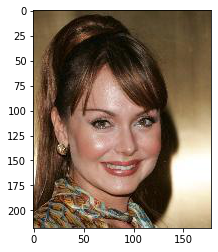

In [3]:
image = tf.keras.preprocessing.image.load_img('../input/celeba-dataset/img_align_celeba/img_align_celeba/000009.jpg')

image = np.array(image)

plt.imshow(image)

In [4]:
attributes = pd.read_csv('../input/celeba-dataset/list_attr_celeba.csv')
print(attributes.columns)
gender = attributes['Male']

## Replacing the -1 values with 0
gender.replace(to_replace=-1, value=0, inplace=True)


print(f'the distribution is:{gender.value_counts()}')

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
the distribution is:0    118165
1     84434
Name: Male, dtype: int64


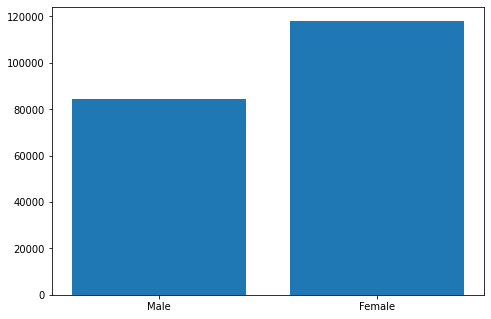

In [5]:
## visualising the class distribution

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
dist = gender.value_counts()
classes = ['Male','Female']
ax.bar(classes,[dist[1],dist[0]])
plt.show()

In [6]:
image_id = attributes['image_id']


## Directory containing the images
dir = '../input/celeba-dataset/img_align_celeba/img_align_celeba/'
images  = [dir + addr for addr in image_id ]
## total images training + validation 
IMG_NUM = 12000
images = images[:IMG_NUM]
gender_arr = gender[:IMG_NUM]
img_arr = []

for n, image in tqdm(enumerate(images), total=len(images)):

    image = cv2.imread(image)
    image = cv2.resize(image,(150,150))
    img_arr.append(image)

100%|██████████| 12000/12000 [01:08<00:00, 174.75it/s]


# processing image data and dividing the data set into training and testing sets

In [7]:
img_arr = np.array(img_arr)
gender_arr = np_utils.to_categorical(gender_arr,2)
## splitting into training and test sets
NUM_TRAIN = 10000

x_train = img_arr[:NUM_TRAIN]
x_valid = img_arr[NUM_TRAIN:]

y_train = gender_arr[:NUM_TRAIN]
y_valid = gender_arr[NUM_TRAIN:]

In [8]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [9]:
inception_model = tf.keras.applications.inception_v3.InceptionV3(weights= 'imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))

x = inception_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
predictions = tf.keras.layers.Dense(2, activation="softmax")(x)


model= tf.keras.models.Model(inputs=inception_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model.layers[:52]:
    layer.trainable = False

# compile the model
model.compile(optimizer = 'adam'
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_____________________________

# **Callbacks**

When training a machine learning model, we would like to have the ability to monitor the model performance and perform certain actions depending on those performance measures. 

**CSVLogger**: a callback streams epoch results to a CSV file.

In [10]:
history = model.fit(x_train,y_train,
                    epochs = 30,
                    validation_data = (x_valid,y_valid),
                    callbacks = [tf.keras.callbacks.CSVLogger('training.csv')]
                   )

Epoch 1/30
313/313 [==============================] - 42s 89ms/step - loss: 0.6526 - accuracy: 0.6719 - val_loss: 1.0258 - val_accuracy: 0.8625
Epoch 2/30
313/313 [==============================] - 26s 82ms/step - loss: 0.2814 - accuracy: 0.8831 - val_loss: 0.2125 - val_accuracy: 0.9265
Epoch 3/30
313/313 [==============================] - 25s 81ms/step - loss: 0.2005 - accuracy: 0.9232 - val_loss: 0.1897 - val_accuracy: 0.9305
Epoch 4/30
313/313 [==============================] - 25s 81ms/step - loss: 0.1686 - accuracy: 0.9332 - val_loss: 0.1837 - val_accuracy: 0.9320
Epoch 5/30
313/313 [==============================] - 25s 81ms/step - loss: 0.1470 - accuracy: 0.9456 - val_loss: 0.1735 - val_accuracy: 0.9305
Epoch 6/30
313/313 [==============================] - 25s 81ms/step - loss: 0.1376 - accuracy: 0.9493 - val_loss: 0.1658 - val_accuracy: 0.9320
Epoch 7/30
313/313 [==============================] - 25s 81ms/step - loss: 0.1222 - accuracy: 0.9548 - val_loss: 0.1631 - val_accuracy:

In [11]:
model.save('model.h5')

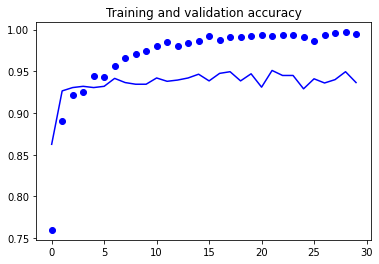

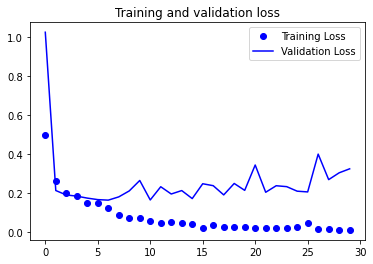

In [12]:
## Visualising the Accuracy and loss plots

callback_csv = pd.read_csv('./training.csv')
acc = callback_csv['accuracy']
val_acc = callback_csv['val_accuracy']
loss = callback_csv['loss']
val_loss = callback_csv['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

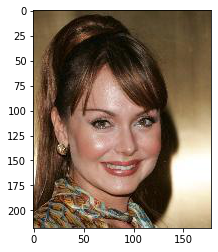

In [13]:
image = tf.keras.preprocessing.image.load_img('../input/celeba-dataset/img_align_celeba/img_align_celeba/000009.jpg')

image = np.array(image)

plt.imshow(image)

# **Resizing the image**

Conventionally, when dealing with images of different sizes in CNN(which happens very often in real world problems), we resize the images to the size of the smallest images with the help of any image manipulation library (OpenCV, PIL etc) or some times, pad the images of unequal size to desired size. Resizing the image is simpler and is used most often

In [14]:

image = cv2.imread('../input/celeba-dataset/img_align_celeba/img_align_celeba/000009.jpg')

image = cv2.resize(image,(150,150))

image = np.array(image)

image = image.reshape(1,150,150,3)

out_arr = model.predict(image)[0]

In [15]:
##  Predicting the one hot encoding as the output
dict  = {1: 'Male', 0: 'Female'}
out_arr = model.predict(image)[0]
print(out_arr)
## converting the one hot encoding to the class output
print(f'Predicted class is : {dict[np.argmax(out_arr)]}')

[1.0000000e+00 2.1733935e-32]
Predicted class is : Female
